In [1]:
import requests
from bs4 import BeautifulSoup
import time
import json
from datetime import datetime
from urllib.parse import urljoin
import sqlite3

In [3]:
def init_database():
    conn = sqlite3.connect('jobs.db')
    c = conn.cursor()
    
    # job_infoテーブルの作成
    c.execute('''
        CREATE TABLE IF NOT EXISTS job_info (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            company_name TEXT,
            location TEXT,
            post_date TEXT,
            title TEXT,
            job_type TEXT,
            employment_type TEXT
        )
    ''')
    
    conn.commit()
    conn.close()

def save_to_database(job_data):
    conn = sqlite3.connect('jobs.db')
    c = conn.cursor()
    
    # リストをカンマ区切りの文字列に変換
    job_type_str = ', '.join(job_data['job_type']) if job_data['job_type'] else ''
    employment_type_str = ', '.join(job_data['employment_type']) if job_data['employment_type'] else ''
    
    # データの挿入
    c.execute('''
        INSERT INTO job_info (
            company_name,
            location,
            post_date,
            title,
            job_type,
            employment_type
        ) VALUES (?, ?, ?, ?, ?, ?)
    ''', (
        job_data['company_name'],
        job_data['location'],
        job_data['post_date'],
        job_data['title'],
        job_type_str,
        employment_type_str
    ))
    
    conn.commit()
    conn.close()

def get_ward_links():
    url = "https://www.baitoru.com/area/tokyo"
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    ward_links = []
    ward_elements = soup.find('div', id='link_job_list_pc_area_all_larea').find_all('label')
    
    target_wards = ['渋谷区']
    
    for element in ward_elements:
        link = element.find('a')
        if link and link.text.strip() in target_wards and not link.get('href', '').startswith('javascript:'):
            ward_url = urljoin('https://www.baitoru.com', link['href'])
            ward_links.append({
                'ward_name': link.text.strip(),
                'url': ward_url
            })
    return ward_links

def get_job_links(ward_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    all_job_links = []
    page = 1
    
    while True:
        if page == 1:
            current_url = ward_url
        else:
            current_url = f"{ward_url}page{page}/"
        
        print(f"Scraping page {page}...")
        response = requests.get(current_url, headers=headers)
        
        if response.status_code != 200:
            break
            
        soup = BeautifulSoup(response.content, 'html.parser')
        articles = soup.find_all('article', class_='list-jobListDetail')
        
        if not articles:
            break
            
        for article in articles:
            link = article.find('a', href=True)
            if link and not link['href'].startswith('javascript:'):
                job_url = urljoin('https://www.baitoru.com', link['href'])
                all_job_links.append(job_url)
        
        page += 1
        time.sleep(2)
    
    return all_job_links

def get_job_details(job_url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    
    try:
        response = requests.get(job_url, headers=headers)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # 会社名取得
        company_name = ''
        company_info_div = soup.find('div', class_='detail-companyInfo')
        if company_info_div:
            company_link = company_info_div.find('a')
            if company_link and not "会社の情報をもっと見る" in company_link.text:
                company_name = company_link.text.strip()
            else:
                company_p = company_info_div.find('p')
                if company_p:
                    company_name = company_p.text.strip()

        if not company_name:
            pt02_element = soup.find('div', class_='pt02')
            if pt02_element:
                company_p = pt02_element.find('p')
                if company_p:
                    company_name = company_p.text.strip()

        if not company_name:
            company_element = soup.find('div', class_='detail-entryInfo')
            if company_element:
                pattern_element = company_element.find('div', class_='pattern-1')
                if pattern_element:
                    company_p = pattern_element.find('p')
                    if company_p:
                        company_name = company_p.text.strip()
        
        # 勤務地取得
        location = ''
        dl04_element = soup.find('dl', class_='dl04')
        if dl04_element:
            address_dl = dl04_element.find('dl', class_='js-da-target')
            if address_dl:
                dt_element = address_dl.find('dt', string='住所')
                if dt_element:
                    li_element = address_dl.find('dd').find('li')
                    if li_element:
                        location = li_element.text.strip().split('\n')[0].strip()
        
        # 掲載日取得
        post_date = ''
        date_element = soup.find('ul', class_='_jobOfferDate')
        if date_element:
            post_date_elem = date_element.find('li', class_='li01')
            if post_date_elem and post_date_elem.find('em'):
                post_date = post_date_elem.find('em').text.strip()
        
        # 求人タイトル取得
        title = ''
        title_element = soup.find('div', class_='detail-detailHeader').find('h2')
        if title_element:
            title = title_element.text.strip()
        
        # 職種と雇用形態取得
        job_type = []
        employment_type = []
        dl01_element = soup.find('dl', class_='dl01')
        if dl01_element:
            job_ul = dl01_element.find('dd').find('ul')
            if job_ul:
                for li in job_ul.find_all('li'):
                    emp_span = li.find('span')
                    if emp_span:
                        emp_text = emp_span.text.strip()
                        if emp_text == '[正]':
                            employment_type.append('正社員')
                        elif emp_text == '[ア・パ]':
                            employment_type.append('アルバイト・パート')
                        else:
                            employment_type.append(emp_text)
                    
                    job_em = li.find('em')
                    if job_em:
                        job_type.append(job_em.text.strip())
        
        return {
            'company_name': company_name,
            'location': location,
            'post_date': post_date,
            'title': title,
            'job_type': job_type,
            'employment_type': employment_type
        }
    
    except Exception as e:
        print(f"Error processing {job_url}: {str(e)}")
        return None

def main():
    # データベースの初期化
    init_database()
    
    ward_links = get_ward_links()
    
    for ward in ward_links:
        print(f"Scraping {ward['ward_name']}...")
        time.sleep(2)
        
        job_links = get_job_links(ward['url'])
        total_jobs = len(job_links)
        print(f"Found {total_jobs} jobs in total")
        
        for i, job_url in enumerate(job_links, 1):
            try:
                time.sleep(1)
                job_details = get_job_details(job_url)
                if job_details:
                    # データベースに保存
                    save_to_database(job_details)
                    print(f"Successfully scraped job: {i}/{total_jobs}")
            except Exception as e:
                print(f"Error scraping job: {str(e)}")
                continue
    
    print("Scraping completed. All data saved to database.")

if __name__ == "__main__":
    main()

Scraping 渋谷区...
Scraping page 1...
Scraping page 2...
Scraping page 3...
Scraping page 4...
Scraping page 5...
Scraping page 6...
Scraping page 7...
Scraping page 8...
Scraping page 9...
Scraping page 10...
Scraping page 11...
Scraping page 12...
Scraping page 13...
Scraping page 14...
Scraping page 15...
Scraping page 16...
Scraping page 17...
Scraping page 18...
Scraping page 19...
Scraping page 20...
Scraping page 21...
Scraping page 22...
Scraping page 23...
Scraping page 24...
Scraping page 25...
Scraping page 26...
Scraping page 27...
Scraping page 28...
Scraping page 29...
Scraping page 30...
Scraping page 31...
Scraping page 32...
Scraping page 33...
Scraping page 34...
Scraping page 35...
Scraping page 36...
Scraping page 37...
Scraping page 38...
Scraping page 39...
Scraping page 40...
Scraping page 41...
Scraping page 42...
Scraping page 43...
Scraping page 44...
Scraping page 45...
Scraping page 46...
Scraping page 47...
Scraping page 48...
Scraping page 49...
Scraping page

In [6]:
def extract_post_date_and_employment_type(database_path='jobs.db'):
    # SQLite データベースへの接続
    conn = sqlite3.connect(database_path)
    c = conn.cursor()
    
    # post_date と employment_type を取得するクエリ
    query = "SELECT post_date, employment_type FROM job_info"
    c.execute(query)
    
    # 結果を取得
    rows = c.fetchall()
    
    conn.close()
    
    # 結果を表示
    for row in rows:
        post_date = row[0]
        employment_type = row[1]
        print(f"{post_date}, {employment_type}")

if __name__ == "__main__":
    extract_post_date_and_employment_type()

2025-01-01, アルバイト・パート
2024-12-30, アルバイト・パート
2024-06-26, アルバイト・パート
2025-01-02, アルバイト・パート, 正社員
2025-01-02, アルバイト・パート, 正社員
2025-01-02, アルバイト・パート, 正社員
2025-01-02, アルバイト・パート, 正社員
2025-01-22, アルバイト・パート
2025-01-08, アルバイト・パート
2025-01-01, アルバイト・パート
2025-01-15, アルバイト・パート
2025-01-22, アルバイト・パート
2025-01-14, [ア・パ][正]
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-20, アルバイト・パート
2025-01-20, アルバイト・パート
2025-01-09, 正社員
2025-01-02, 正社員
2025-01-16, アルバイト・パート
2025-01-16, 正社員
2025-01-08, アルバイト・パート
2024-05-14, [業務委託]
2025-01-22, アルバイト・パート
2024-06-24, アルバイト・パート
2025-01-22, アルバイト・パート
2025-01-22, [ア・パ][正], 正社員
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2024-11-26, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-13, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-14, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-14, アルバイト・パート
2025-01-21, アルバイト・パート
2025-01-20, アルバイト・パート
2025-01-13, アルバイト・パート
2025-01-

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

def map_employment_type(employment_type_str):
    types = employment_type_str.split(',')
    types = [t.strip() for t in types]
    
    if 'アルバイト・パート' in types and '正社員' in types:
        return 3
    elif '正社員' in types:
        return 2
    elif 'アルバイト・パート' in types:
        return 1
    else:
        return 0  # どちらでもない場合

def convert_date_format(date_str):
    try:
        date_obj = datetime.strptime(date_str, "%Y-%m-%d")
        return date_obj.strftime("%Y%m%d")
    except ValueError as e:
        print(f"Error converting date: {e}")
        return None
    
def extract_and_transform_data(database_path='jobs.db'):
    conn = sqlite3.connect(database_path)
    c = conn.cursor()
    
    # post_date と employment_type を取得するクエリ
    # 2024年9月1日以降のデータを取得
    query = "SELECT post_date, employment_type FROM job_info WHERE post_date >= '2024-09-01'"
    c.execute(query)
    
    rows = c.fetchall()
    
    conn.close()
    
    transformed_data = []
    for row in rows:
        post_date = row[0]
        employment_type_str = row[1]

        # 日付のフォーマットを変換して標準の "YYYYMMDD" フォーマットに
        formatted_date = convert_date_format(post_date)

        # 雇用形態を数値にマッピング
        employment_type = map_employment_type(employment_type_str)
        
        # 変換されたデータをリストに追加
        if formatted_date:  # 有効な日付のみを追加
            transformed_data.append((formatted_date, employment_type))
    
    return transformed_data

# データを表示
data = extract_and_transform_data()
df = pd.DataFrame(data, columns=['post_date', 'employment_type'])
print(df)



     post_date  employment_type
0     20250101                1
1     20241230                1
2     20250102                3
3     20250102                3
4     20250102                3
...        ...              ...
4586  20241001                1
4587  20240901                0
4588  20240927                2
4589  20240919                1
4590  20240919                1

[4591 rows x 2 columns]


In [27]:
def create_weekly_data(df):
    df['post_date'] = pd.to_datetime(df['post_date'], format='%Y%m%d')
    df['week_start'] = df['post_date'].dt.to_period('W').apply(lambda r: r.start_time)
    employment_counts = df.groupby(['week_start', 'employment_type']).size().unstack(fill_value=0)
    return employment_counts

def plot_employment_counts(employment_counts):
    employment_counts = employment_counts.reindex(columns=[0, 1, 2, 3])
    employment_counts.plot(kind='bar', stacked=True, figsize=(15, 7))
    plt.title("Employment Types Count by Week")
    plt.xlabel("Week Starting")
    plt.ylabel("Count")
    plt.legend(title="Employment Type", labels=["Undefined", "Part-time", "Full-time", "Both"])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Employment Counts by Week:
employment_type    0    1   2  3
week_start                      
2024-08-26        17   27   0  0
2024-09-02        10   12   0  1
2024-09-09        14    7   4  4
2024-09-16        16    6   0  0
2024-09-23         6    9   2  0
2024-09-30        30   44   2  1
2024-10-07        34   18   7  0
2024-10-14        18   16   7  0
2024-10-21        18   27   0  0
2024-10-28        33  120  17  2
2024-11-04        26   24   5  0
2024-11-11        29   14  23  0
2024-11-18        47    7   3  0
2024-11-25        55  121   6  0
2024-12-02        78   41   8  2
2024-12-09        96   64  42  0
2024-12-16       108   46   4  1
2024-12-23       206   63   6  0
2024-12-30       250  331  34  5
2025-01-06       406  275  50  2
2025-01-13       595  217  23  2
2025-01-20       588  144  15  0


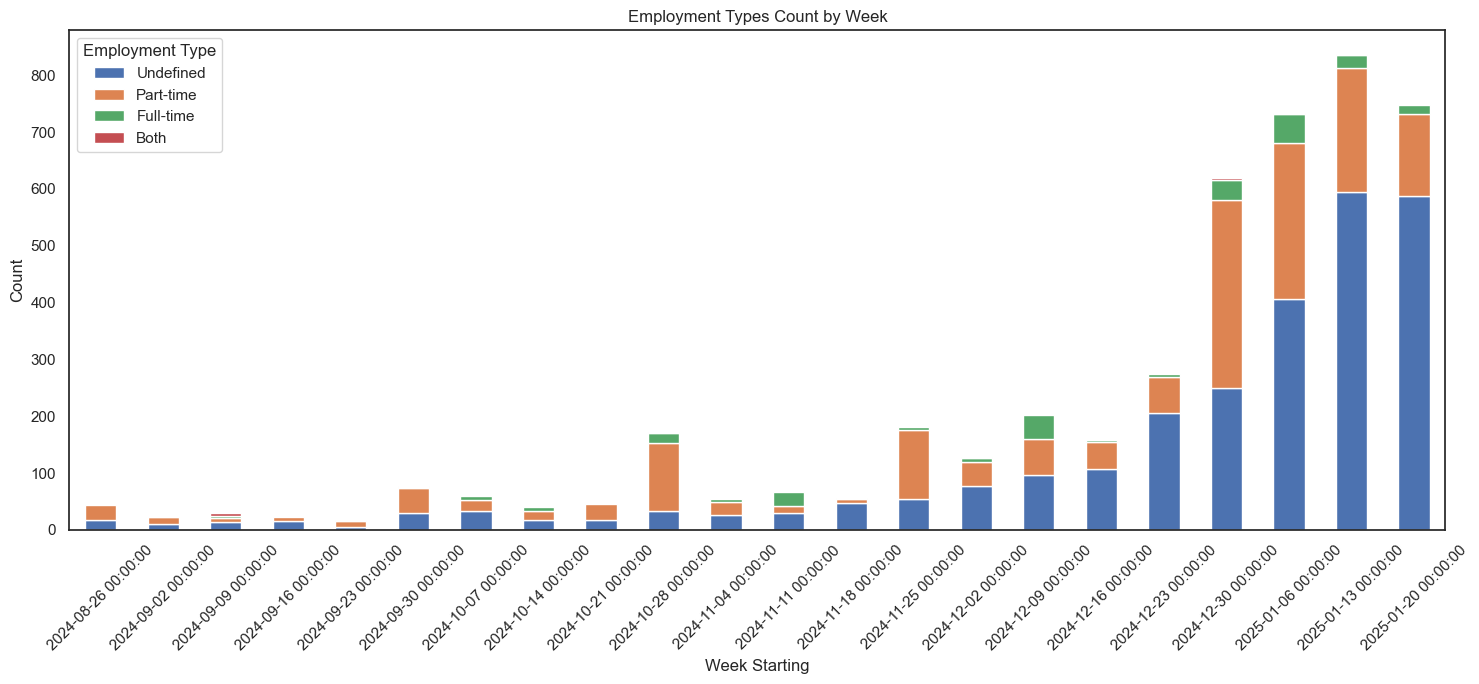

In [28]:

def main():
    transformed_data = extract_and_transform_data()
    
    # データをデータフレームに変換
    df = pd.DataFrame(transformed_data, columns=['post_date', 'employment_type'])
    
    # データの週ごと集計
    employment_counts = create_weekly_data(df)
    
    # 集計結果の表示
    print("Employment Counts by Week:")
    print(employment_counts)
    
    # 雇用形態のカウントをプロット
    plot_employment_counts(employment_counts)

if __name__ == "__main__":
    main()